In [54]:
CONFIG_PATH = '../config.json'
SPLIT = 'test'
IOU_THRESHOLD = 0.7

In [55]:
# Load config
import json
import numpy as np
from pathlib import Path

### Подготавливаем визуализацию

In [56]:
# Create temporary directory for predictions
pred_labels_dir = Path('runs/segment/predict/labels')
pred_images_dir = Path('runs/segment/predict')

In [57]:
with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

In [58]:
from matplotlib import pyplot as plt
import numpy as np

In [59]:
def group_len(g, border=True):
    return len([1 for m in g if border or not m['is_border']])
def group_matches(g, border=True):
    return sum(m['is_matched'] for m in g if border or not m['is_border'])
def calculate_integrated_precision(pred_groups, int_thr, border=True):
    matches = len([1 for g in pred_groups if group_matches(g, border) > 0 and group_len(g, border) >= int_thr])
    total = len([1 for g in pred_groups if group_len(g, border) >= int_thr])
    return matches / total

def calculate_integrated_recall(gt_groups, int_thr, border=True):
    matches = len([1 for g in gt_groups if group_matches(g, border) >= int_thr])
    total = len(gt_groups)
    return matches / total

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

def plot_match_probability(groupset, title):
    # Collect area shares and match status
    area_shares = []
    is_matched = []
    for g in groupset:
        for instance in g:
            area_shares.append(instance['area_share'])
            is_matched.append(instance['is_matched'])

    # Convert to numpy arrays
    area_shares = np.array(area_shares)
    is_matched = np.array(is_matched)

    # Create bins and calculate probabilities
    bins = np.linspace(area_shares.min(), area_shares.max(), 16)
    bin_indices = np.digitize(area_shares, bins) - 1
    probabilities = []
    bin_centers = []

    for i in range(len(bins)-1):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            prob = np.mean(is_matched[mask])
            probabilities.append(prob)
            bin_centers.append((bins[i] + bins[i+1]) / 2)

    # Apply Gaussian smoothing
    probabilities = np.array(probabilities)
    smoothed_probabilities = gaussian_filter(probabilities, sigma=2)

    # Plot probability distribution
    plt.plot(bin_centers, probabilities, 'o', alpha=0.3, label='Raw data')
    plt.plot(bin_centers, smoothed_probabilities, '-', label='Smoothed')
    plt.ylim(0, 1)
    plt.xlabel('Area Share')
    plt.ylabel('Probability of Match')
    plt.title(f'Probability of Match vs Area Share - {title}')
    plt.grid(True)
    plt.legend()


In [61]:
def plot_area_distribution(gt_groups, pred_groups, config):
    # Plot area distribution histograms
    plt.figure(figsize=(15, 6))

    # Ground Truth histogram
    plt.subplot(1, 2, 1)
    gt_areas = [instance['area'] / (config['imgsz'] * config['imgsz']) 
                for group in gt_groups 
                for instance in group]
    plt.hist(gt_areas, bins=50, alpha=0.7)
    plt.xlabel('Area Share')
    plt.ylabel('Count')
    plt.title('Area Distribution - Ground Truth')
    plt.grid(True)

    # Predictions histogram
    plt.subplot(1, 2, 2)
    pred_areas = [instance['area'] / (config['imgsz'] * config['imgsz']) 
                for group in pred_groups 
                for instance in group]
    plt.hist(pred_areas, bins=50, alpha=0.7)
    plt.xlabel('Area Share')
    plt.ylabel('Count')
    plt.title('Area Distribution - Predictions')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [62]:
from scipy import stats

def get_correlation_data(groupset):
    area_shares = []
    is_matched = []
    for g in groupset:
        for instance in g:
            area_shares.append(instance['area_share'])
            is_matched.append(instance['is_matched'])
    return np.array(area_shares), np.array(is_matched)

def calculate_pcorr(gt_groups, pred_groups):
    # Get data for GT and Pred
    gt_areas, gt_matched = get_correlation_data(gt_groups)
    pred_areas, pred_matched = get_correlation_data(pred_groups)

    # Combine data for total
    total_areas = np.concatenate([gt_areas, pred_areas])
    total_matched = np.concatenate([gt_matched, pred_matched])

    # Calculate correlations and p-values
    gt_corr, gt_pval = stats.pearsonr(gt_areas, gt_matched)
    pred_corr, pred_pval = stats.pearsonr(pred_areas, pred_matched)
    total_corr, total_pval = stats.pearsonr(total_areas, total_matched)

    # Print results in a formatted table
    print(f"{'Dataset':<10} {'Correlation':>12} {'P-value':>12}")
    print("-" * 34)
    print(f"{'GT':<10} {gt_corr:>12.4f} {gt_pval:>12.4e}")
    print(f"{'Pred':<10} {pred_corr:>12.4f} {pred_pval:>12.4e}")
    print(f"{'Total':<10} {total_corr:>12.4f} {total_pval:>12.4e}")

In [63]:
def get_match_probability(groupset, a, b):
    # Collect area shares and match status
    area_shares = []
    is_matched = []
    for g in groupset:
        for instance in g:
            area_shares.append(instance['area_share'])
            is_matched.append(instance['is_matched'])
    
    # Convert to numpy arrays
    area_shares = np.array(area_shares)
    is_matched = np.array(is_matched)
    
    # Find objects within the specified range
    mask = (area_shares >= a) & (area_shares <= b)
    
    # Calculate probability if there are objects in the range
    if np.sum(mask) > 0:
        probability = np.mean(is_matched[mask])
        return probability
    else:
        return None

## Разреженный тест

In [90]:
import pickle
with open('gt_test_sparse.pkl', 'rb') as f:
    gt_groups = pickle.load(f)
with open('pred_test_sparse.pkl', 'rb') as f:
    pred_groups = pickle.load(f)

Median group size: 22


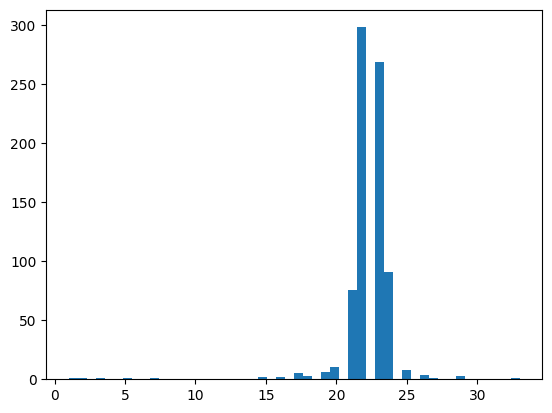

In [91]:
plt.hist([len(g) for g in gt_groups], bins=50)
median_length = int(np.median([len(g) for g in gt_groups]))
print(f"Median group size: {median_length}")

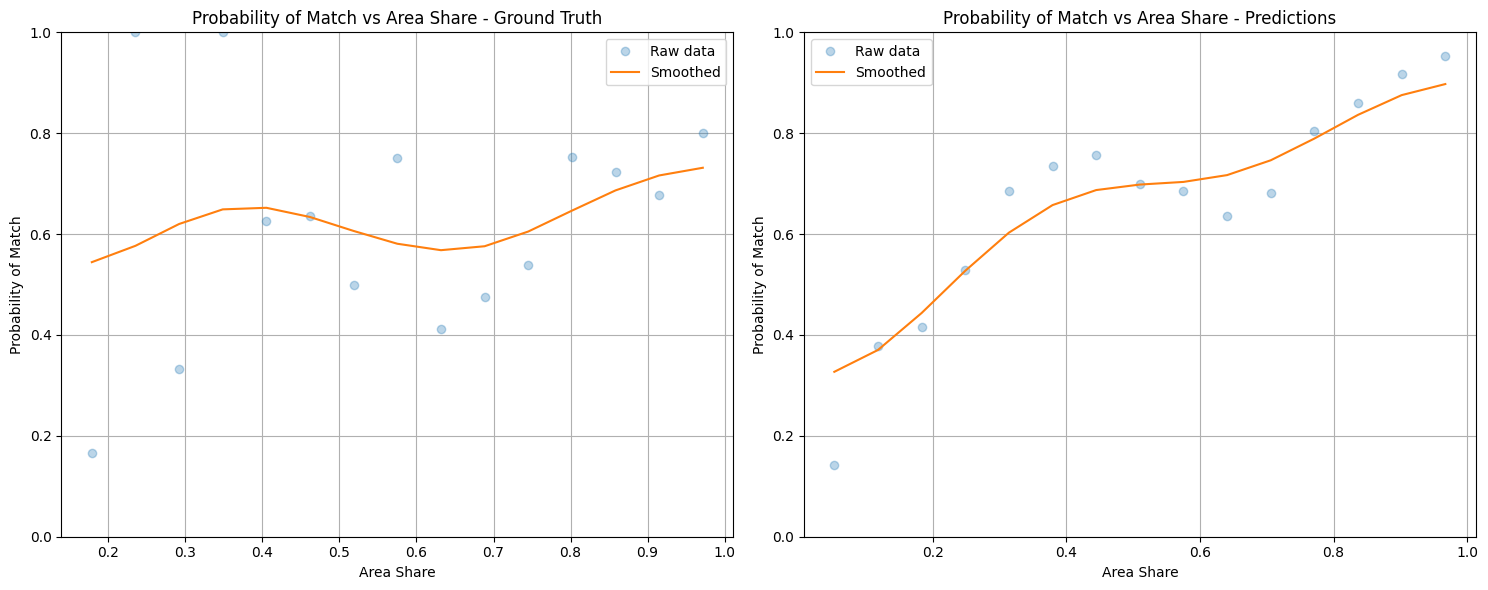

In [92]:
# Create subplots
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plot_match_probability(gt_groups, 'Ground Truth')
plt.subplot(1, 2, 2)
plot_match_probability(pred_groups, 'Predictions')
plt.tight_layout()
plt.show()

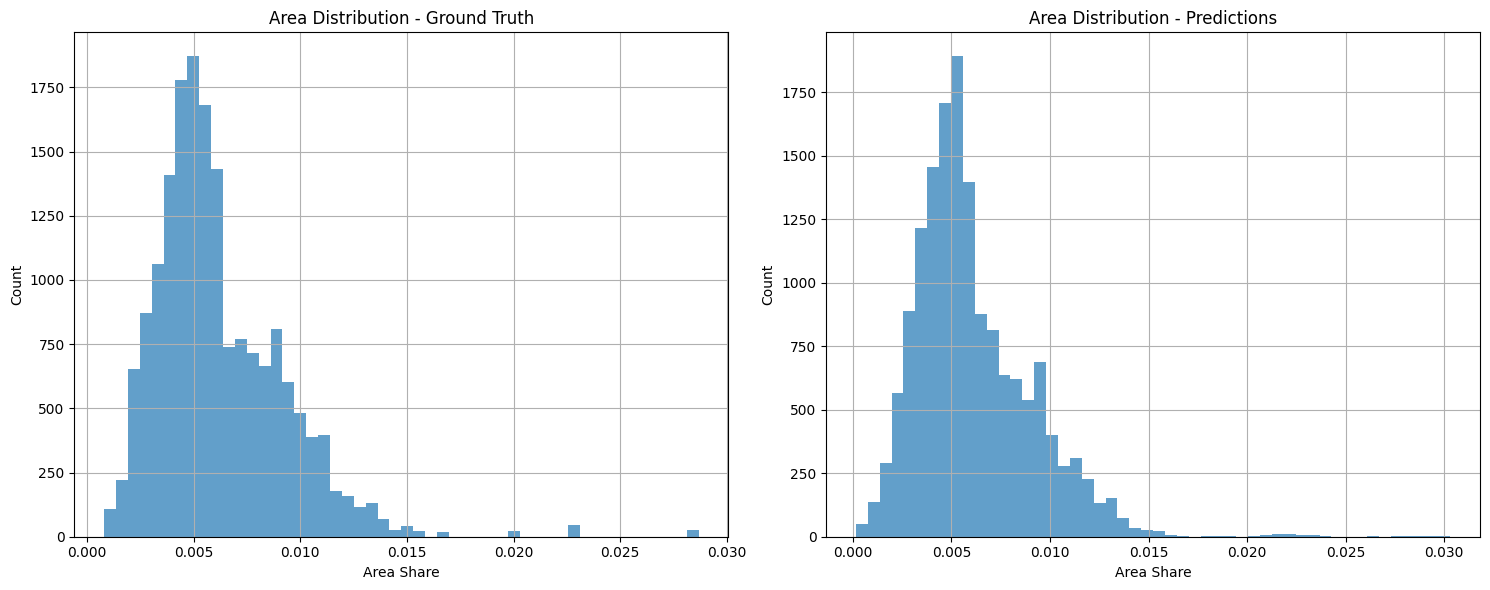

In [93]:
plot_area_distribution(gt_groups, pred_groups, config)

In [94]:
calculate_pcorr(gt_groups, pred_groups)

Dataset     Correlation      P-value
----------------------------------
GT               0.0614   4.1875e-16
Pred             0.2817  1.1814e-280
Total            0.1025   8.3264e-78


In [95]:
print("GT match probability:  ", float(get_match_probability(gt_groups, 0.0, 1.0)))
print("Pred match probability:", float(get_match_probability(pred_groups, 0.0, 1.0)))

GT match probability:   0.7884274861483977
Pred match probability: 0.890845751886975


#### Все объекты

In [96]:
print("Per-mask precision:", (bpm_p := np.array([float(m['is_matched']) for g in pred_groups for m in g]).mean()))
print("Per-obj precision:", (bpo_p := np.array([max(float(m['is_matched']) for m in g) for g in pred_groups]).mean()))

Per-mask precision: 0.890845751886975
Per-obj precision: 0.8038379530916845


In [97]:
print("Per-mask recall:", (bpm_r := np.array([float(m['is_matched']) for g in gt_groups for m in g]).mean()))
print("Per-obj recall:", (bpo_r := np.array([max(float(m['is_matched']) for m in g) for g in gt_groups]).mean()))

Per-mask recall: 0.7884274861483977
Per-obj recall: 0.9566326530612245


In [98]:
print("Per-mask F1:", bpm_p * bpm_r / (bpm_p + bpm_r) * 2)
print("Per-obj F1:", bpo_p * bpo_r / (bpo_p + bpo_r) * 2)

Per-mask F1: 0.8365133925768334
Per-obj F1: 0.8736046270920939


#### Без краевых объектов

In [99]:
print("Per-mask precision:", (pm_p := np.array([float(m['is_matched']) for g in pred_groups for m in g if not m['is_border']]).mean()))
print("Per-obj precision:", (po_p := np.array([max(float(m['is_matched']) for m in g if not m['is_border']) for g in pred_groups if len([float(m['is_matched']) for m in g if not m['is_border']]) > 0]).mean()))

Per-mask precision: 0.9045704121877658
Per-obj precision: 0.831081081081081


In [100]:
print("Per-mask recall:", (pm_r := np.array([float(m['is_matched']) for g in gt_groups for m in g if not m['is_border']]).mean()))
print("Per-obj recall:", (po_r := np.array([max([float(m['is_matched']) for m in g if not m['is_border']] + [0]) for g in gt_groups if len([float(m['is_matched']) for m in g if not m['is_border']]) > 0]).mean()))

Per-mask recall: 0.8567672193411731
Per-obj recall: 0.9450127877237852


In [101]:
print("Per-mask F1:", pm_p * pm_r / (pm_p + pm_r) * 2)
print("Per-obj F1:", po_p * po_r / (po_p + po_r) * 2)

Per-mask F1: 0.880020119794593
Per-obj F1: 0.8843927261405541


#### Доля ошибок классификации


In [102]:
print("GT per-mask ratio:", np.array([float(m['is_mask_matched']) for g in gt_groups for m in g if not m['is_matched']]).mean())
print("GT per-obj ratio:", np.array([max(float(m['is_mask_matched']) for m in g) for g in gt_groups if max(float(m['is_matched']) for m in g) == False]).mean())

GT per-mask ratio: 0.03779697624190065
GT per-obj ratio: 0.35294117647058826


In [103]:
print("Pred per-mask ratio:", np.array([float(m['is_mask_matched']) for g in pred_groups for m in g if not m['is_matched']]).mean())
print("Pred per-obj ratio:", np.array([max(float(m['is_mask_matched']) for m in g) for g in pred_groups if max(float(m['is_matched']) for m in g) == False]).mean())

Pred per-mask ratio: 0.09515366430260047
Pred per-obj ratio: 0.07608695652173914


### Гипотеза о зависимости обрезанности и качества распознавания

In [104]:
gt_is_matched = []
gt_is_border = []
pred_is_matched = []
pred_is_border = []

for group in gt_groups:
    for obj in group:
        gt_is_matched.append(obj['is_matched'])
        gt_is_border.append(obj['is_border'])
        
for group in pred_groups:
    for obj in group:
        pred_is_matched.append(obj['is_matched'])
        pred_is_border.append(obj['is_border'])

is_matched = {"Pred": pred_is_matched, "GT": gt_is_matched, 'Total': pred_is_matched + gt_is_matched}
is_border = {"Pred": pred_is_border, "GT": gt_is_border, 'Total': pred_is_border + gt_is_border}

In [105]:
from scipy.stats import spearmanr

print("| Sample | Spearman correlation | p-value               |")
print("|--------|----------------------|-----------------------|")
for sample in ['GT', 'Pred', 'Total']:
    corr, p_value = spearmanr(is_border[sample], is_matched[sample])
    print(f"| {sample:>6} | {corr:>20.6f} | {p_value:>21} |")

| Sample | Spearman correlation | p-value               |
|--------|----------------------|-----------------------|
|     GT |            -0.316939 |                   0.0 |
|   Pred |            -0.098726 | 7.004538510023667e-35 |
|  Total |            -0.239966 |                   0.0 |


### Количество объектов, предсказанных только по краевым объектам

In [106]:
def get_border_only_matched(groups):
    border_only_matched = []
    border_only_matched_ids = []
    for i, group in enumerate(groups):
        border_matched = False
        non_border_matched = False
        non_border_found = False
        for obj in group:
            if obj['is_matched']:
                if obj['is_border']:
                    border_matched = True
                else:
                    non_border_matched = True
            if not obj['is_border']:
                non_border_found = True
        if border_matched and not non_border_matched and non_border_found:
            border_only_matched.append(group)
            border_only_matched_ids.append(i)
    return border_only_matched, border_only_matched_ids

In [107]:
gt_border_only, gt_border_ids = get_border_only_matched(gt_groups)
pred_border_only, pred_border_ids = get_border_only_matched(pred_groups)

In [108]:
print("GT:", len(gt_border_only), "elements", "out of", len(gt_groups), f"({len(gt_border_only) / len(gt_groups) * 100:.2f}%)")
print("Pred:", len(pred_border_only), "elements", "out of", len(pred_groups), f"({len(pred_border_only) / len(pred_groups) * 100:.2f}%)")

GT: 9 elements out of 784 (1.15%)
Pred: 9 elements out of 938 (0.96%)


### Пороговая интеграция

In [109]:
def find_best_int_thr(border : bool):
    thresholds = range(1, median_length + 1)
    precisions = []
    recalls    = []
    f1_scores  = []

    for threshold in thresholds:
        precision = calculate_integrated_precision(pred_groups, threshold, border)
        recall = calculate_integrated_recall(gt_groups, threshold, border)
        f1 = 2 * (precision * recall) / (precision + recall)

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
    plt.plot(thresholds, precisions, marker='s', label='Precision')
    plt.plot(thresholds, recalls, marker='^', label='Recall')
    plt.xlabel('Integration Threshold')
    plt.ylabel('Score')
    plt.title(f'Metrics vs Integration Threshold (Border: {border})')
    plt.legend()
    plt.grid(True)
    plt.show()

    max_f1 = max(f1_scores)
    max_f1_threshold = thresholds[f1_scores.index(max_f1)]
    print(f"Max F1: {max_f1:.3f} at threshold {max_f1_threshold}")

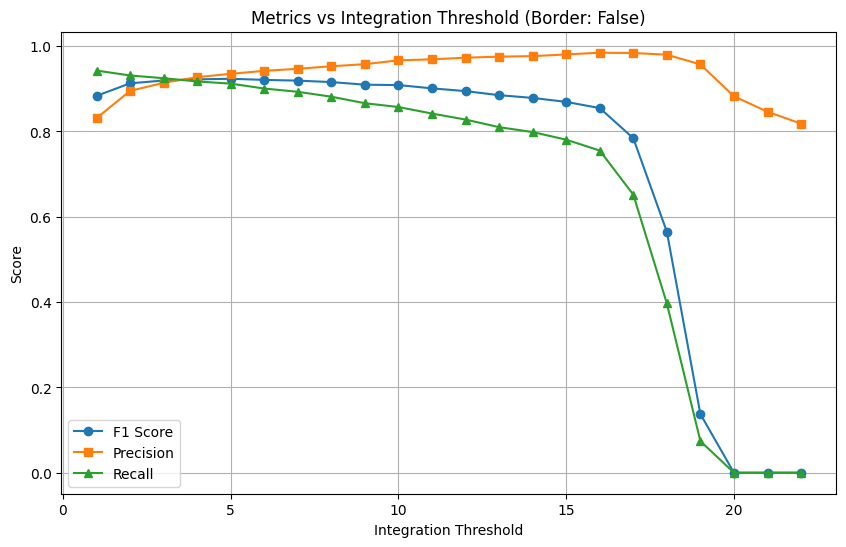

Max F1: 0.923 at threshold 5


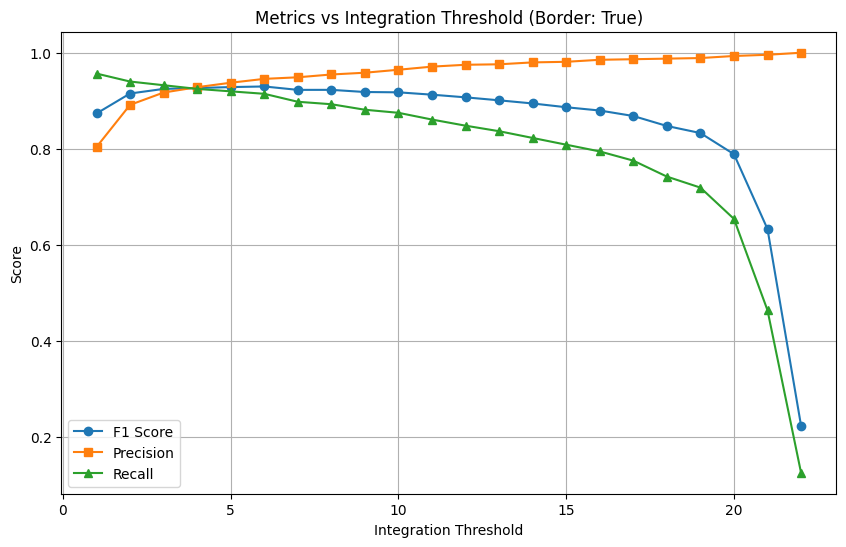

Max F1: 0.930 at threshold 6


In [110]:
find_best_int_thr(border=False)
find_best_int_thr(border=True)